# Network Traffic Analysis *Project*

In class we have covered binary classification (e.g., spam v. ham, fake v. real etc.). In this assignment, you will perform multi-class classification using the network traffic data.

We want you to do this in two ways:

**Direct Multi-Class Classification [KNN [Done], DT [Done], NN, etc]**

Directly use our previous methods for binary classification (Decision Trees, KNN, Perceptron, Neural Networks) to predict multiple classes.

**Direct Multi-Class Classification with Resampling [Done]**

Resample the large, unbalanced dataset to have a smaller and more balanced dataset for classifier

**Today: Hierarchical Multi-Class Classification**

Perform binary classification first (benign vs. malicious). Once a sample has been identified as malicious, perform multi-class classification to identify what kind of malicious activity is occurring.


In [1]:
# 10/25 Cla
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


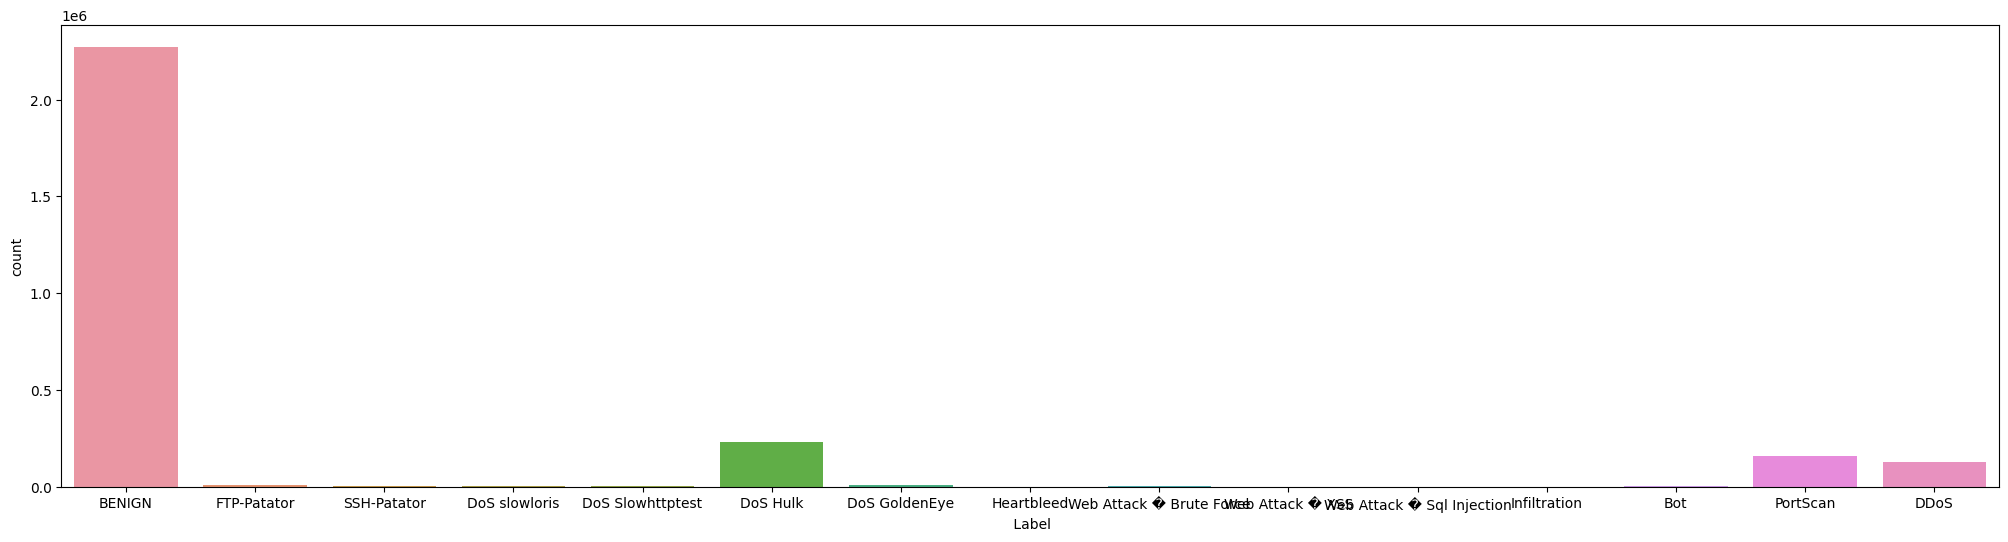

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

folder_path = '/content/drive/MyDrive/CS345/MachineLearningCSV/MachineLearningCVE/'
df = pd.read_csv(folder_path + 'clean_traffic_data.csv')
fig = plt.figure(figsize=(25,6))
sns.countplot(x=' Label', data=df)
plt.show()

## Hierarchical Multi-Class Classification

## 1st layer of training: classify BENIGN and MALICIOUS activities

In [3]:
import numpy as np
import pandas as pd
np.random.seed = 1

label_set = set(df[' Label'])
train_df_list = []
test_df_list = []
print('-'*60)


for label in label_set:
  mask = np.random.rand(len(df[df[' Label'] == label])) < 0.8
  train_df_list.append(df[df[' Label'] == label][mask])
  test_df_list.append(df[df[' Label'] == label][~mask])

df_train = pd.concat(train_df_list)
df_test = pd.concat(test_df_list)

print('-'*60)
print('check if testing set contains all the categories:', set(df_train[' Label']) == set(df_test[' Label']))
print('-'*60)
for label in label_set:
  print('num training samplesfor "{}": {}'.format(label, len(df_train[df_train[' Label'] == label])))
  print('num testing samplesfor "{}": {}'.format(label, len(df_test[df_test[' Label'] == label])))

------------------------------------------------------------
------------------------------------------------------------
check if testing set contains all the categories: True
------------------------------------------------------------
num training samplesfor "Web Attack � Sql Injection": 18
num testing samplesfor "Web Attack � Sql Injection": 3
num training samplesfor "Web Attack � Brute Force": 1202
num testing samplesfor "Web Attack � Brute Force": 305
num training samplesfor "Heartbleed": 9
num testing samplesfor "Heartbleed": 2
num training samplesfor "DoS GoldenEye": 8174
num testing samplesfor "DoS GoldenEye": 2119
num training samplesfor "Bot": 1542
num testing samplesfor "Bot": 424
num training samplesfor "DoS Hulk": 185224
num testing samplesfor "DoS Hulk": 45849
num training samplesfor "BENIGN": 1818740
num testing samplesfor "BENIGN": 454357
num training samplesfor "SSH-Patator": 4699
num testing samplesfor "SSH-Patator": 1198
num training samplesfor "DoS slowloris": 4652

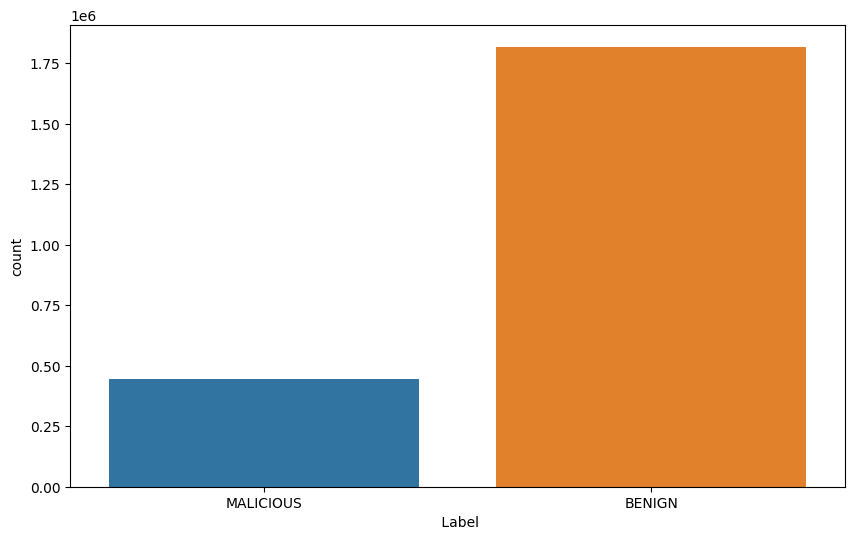

In [4]:
# train a binary classifier

df_binary = df_train.copy()
df_binary.loc[df_binary[' Label'] != 'BENIGN', ' Label'] = 'MALICIOUS'

fig = plt.figure(figsize = (10,6))
sns.countplot(x=' Label', data=df_binary)
plt.show()

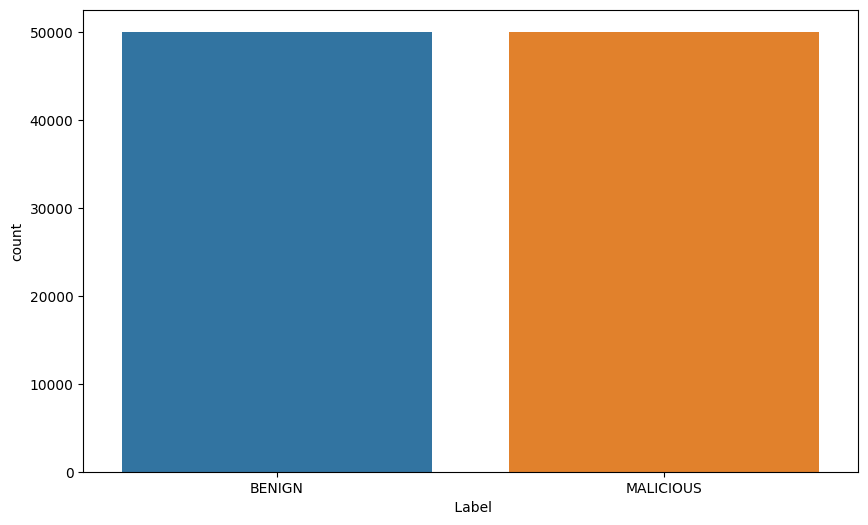

In [5]:
# train a binary model
# reduce and balance binary dataset using resampling/downsampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={'BENIGN':50000, "MALICIOUS": 50000}, random_state=1)

X = df_binary[df_binary.columns[:-1]]
y = df_binary[df_binary.columns[-1]]
X_resampled, y_resampled = rus.fit_resample(X, y)
resampled_df_binary = pd.DataFrame(columns=df_binary.columns)
resampled_df_binary[resampled_df_binary.columns[:-1]] = X_resampled
resampled_df_binary[resampled_df_binary.columns[-1]] = y_resampled

# check histogram of resample data
fig = plt.figure(figsize = (10,6))
sns.countplot(x=' Label', data=resampled_df_binary)
plt.show()

In [6]:
# split the resampled training data into train and test 10%
import numpy as np
np.random.seed = 0

# gen train and validation set
mask = np.random.rand(len(resampled_df_binary)) < 0.9
train_set = resampled_df_binary[mask]
val_set = resampled_df_binary[~mask]

X_train = train_set[train_set.columns[:-1]]
y_train = train_set[train_set.columns[-1]]
X_val = val_set[val_set.columns[:-1]]
y_val = val_set[val_set.columns[-1]]

# model training
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

mlp = MLPClassifier(hidden_layer_sizes=(40,), random_state=1, max_iter=300).fit(X_train, y_train)
pred_val = mlp.predict(X_val)

print('Validation Accurcacy"', accuracy_score(pred_val, y_val))
df_binary_test = df_test.copy()
df_binary_test.loc[df_binary_test[' Label'] != 'BENIGN', ' Label'] = 'MALICIOUS'

X_test = df_binary_test[df_binary_test.columns[:-1]]
y_test = df_binary_test[df_binary_test.columns[-1]]

pred_test = mlp.predict(X_test)
print('Testing Accuracy', accuracy_score(pred_test, y_test))
print(classification_report(y_test, pred_test))

Validation Accurcacy" 0.9336915745716313
Testing Accuracy 0.908195127126136
              precision    recall  f1-score   support

      BENIGN       0.99      0.89      0.94    454357
   MALICIOUS       0.69      0.97      0.81    111223

    accuracy                           0.91    565580
   macro avg       0.84      0.93      0.87    565580
weighted avg       0.93      0.91      0.91    565580



In [7]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier().fit(X_train, y_train)

pred_val = rfc.predict(X_val)
print('Validation Accurcacy"', accuracy_score(pred_val, y_val))

pred_test = rfc.predict(X_test)
print('Testing Accuracy', accuracy_score(pred_test, y_test))
print(classification_report(y_test, pred_test))

Validation Accurcacy" 0.9970597181384974
Testing Accuracy 0.998459987976944
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454357
   MALICIOUS       0.99      1.00      1.00    111223

    accuracy                           1.00    565580
   macro avg       1.00      1.00      1.00    565580
weighted avg       1.00      1.00      1.00    565580




## 2nd layer of Training: Classify different types of malicious activities

In [8]:
import numpy as np
import pandas as pd
np.random.seed = 1

label_set = set(df[' Label'])
train_df_list = []
test_df_list = []
print('-'*60)


for label in label_set:
  mask = np.random.rand(len(df[df[' Label'] == label])) < 0.8
  print(label, len(mask))
  train_df_list.append(df[df[' Label'] == label][mask])
  test_df_list.append(df[df[' Label'] == label][~mask])

df_train = pd.concat(train_df_list)
df_test = pd.concat(test_df_list)

# remove benign samples
df_malicious_train = df_train[df_train[' Label'] != 'BENIGN'].copy()
df_malicious_test = df_test[df_test[' Label'] != 'BENIGN'].copy()

print('checking res', set(df_malicious_train[' Label']) == set(df_malicious_test[' Label']))

------------------------------------------------------------
Web Attack � Sql Injection 21
Web Attack � Brute Force 1507
Heartbleed 11
DoS GoldenEye 10293
Bot 1966
DoS Hulk 231073
BENIGN 2273097
SSH-Patator 5897
DoS slowloris 5796
Web Attack � XSS 652
Infiltration 36
DDoS 128027
PortScan 158930
FTP-Patator 7938
DoS Slowhttptest 5499
checking res {'Web Attack � Sql Injection', 'Web Attack � Brute Force', 'Bot', 'DoS GoldenEye', 'Heartbleed', 'DoS Hulk', 'SSH-Patator', 'DoS slowloris', 'Web Attack � XSS', 'Infiltration', 'DDoS', 'PortScan', 'FTP-Patator', 'DoS Slowhttptest'} {'Web Attack � Sql Injection', 'Web Attack � Brute Force', 'Bot', 'DoS GoldenEye', 'Heartbleed', 'DoS Hulk', 'SSH-Patator', 'DoS slowloris', 'Web Attack � XSS', 'Infiltration', 'DDoS', 'PortScan', 'FTP-Patator', 'DoS Slowhttptest'}


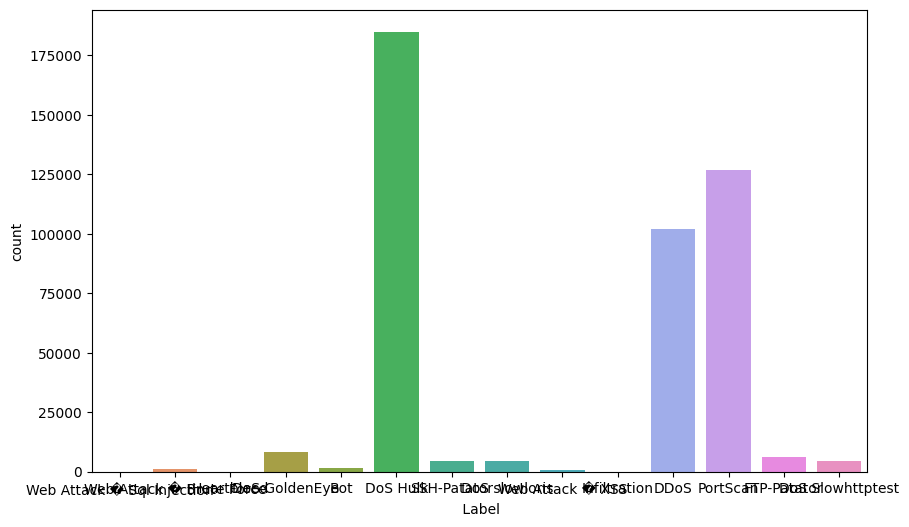

In [9]:
fig = plt.figure(figsize = (10,6))
sns.countplot(x=' Label', data=df_malicious_train)
plt.show()

In [10]:
# use randomforest calssifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

X_train = df_malicious_train[df_malicious_train.columns[:-1]]
y_train = df_malicious_train[df_malicious_train.columns[-1]]

X_test = df_malicious_test[df_malicious_test.columns[:-1]]
y_test = df_malicious_test[df_malicious_test.columns[-1]]

rfc = RandomForestClassifier().fit(X_train, y_train)

# ??? classification report stuff
pred = rfc.predict(X_test)
print(accuracy_score(pred, y_test))
print(classification_report(y_test, pred))


0.9981927980317602
                            precision    recall  f1-score   support

                       Bot       1.00      1.00      1.00       379
                      DDoS       1.00      1.00      1.00     25824
             DoS GoldenEye       1.00      1.00      1.00      2066
                  DoS Hulk       1.00      1.00      1.00     46092
          DoS Slowhttptest       1.00      0.99      1.00      1116
             DoS slowloris       0.99      1.00      1.00      1148
               FTP-Patator       1.00      1.00      1.00      1586
                Heartbleed       1.00      1.00      1.00         4
              Infiltration       1.00      1.00      1.00         5
                  PortScan       1.00      1.00      1.00     31901
               SSH-Patator       1.00      1.00      1.00      1198
  Web Attack � Brute Force       0.72      0.80      0.75       320
Web Attack � Sql Injection       0.67      0.67      0.67         3
          Web Attack � XSS  

In [11]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy={'Infiltration': 400}, random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

resampled_df_malicious_train = pd.DataFrame(columns=df_malicious_train.columns)
resampled_df_malicious_train[resampled_df_malicious_train.columns[:-1]] = X_resampled
resampled_df_malicious_train[resampled_df_malicious_train.columns[-1]] = y_resampled

# prediction
pred = rfc.predict(X_test)
print(accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

# fig = plt.figure(10,6)
# sns.countplot(x=' Label', data=resampled_df_malicious_train)
# plt.show()

#### this video is on 10/30 to catch up on some missed stuff

0.9981927980317602
                            precision    recall  f1-score   support

                       Bot       1.00      1.00      1.00       379
                      DDoS       1.00      1.00      1.00     25824
             DoS GoldenEye       1.00      1.00      1.00      2066
                  DoS Hulk       1.00      1.00      1.00     46092
          DoS Slowhttptest       1.00      0.99      1.00      1116
             DoS slowloris       0.99      1.00      1.00      1148
               FTP-Patator       1.00      1.00      1.00      1586
                Heartbleed       1.00      1.00      1.00         4
              Infiltration       1.00      1.00      1.00         5
                  PortScan       1.00      1.00      1.00     31901
               SSH-Patator       1.00      1.00      1.00      1198
  Web Attack � Brute Force       0.72      0.80      0.75       320
Web Attack � Sql Injection       0.67      0.67      0.67         3
          Web Attack � XSS  

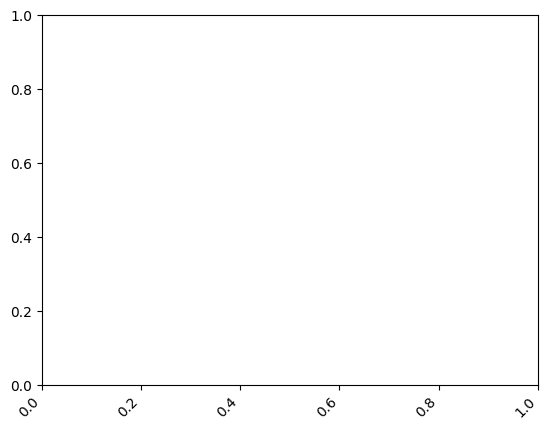

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot(colorbar=False)
plt.xticks(rotation=45, ha='right')
plt.show()

## 3rd layer of classification
here web attack


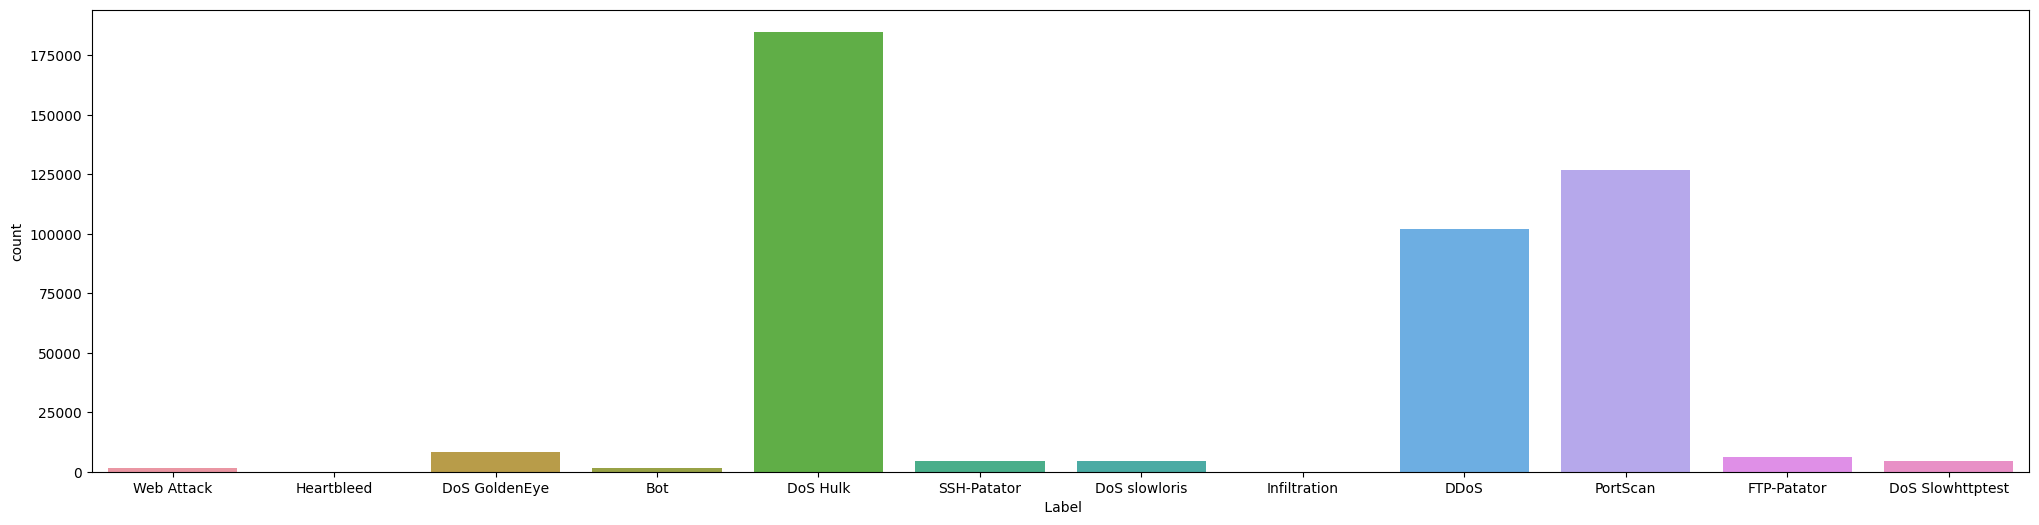

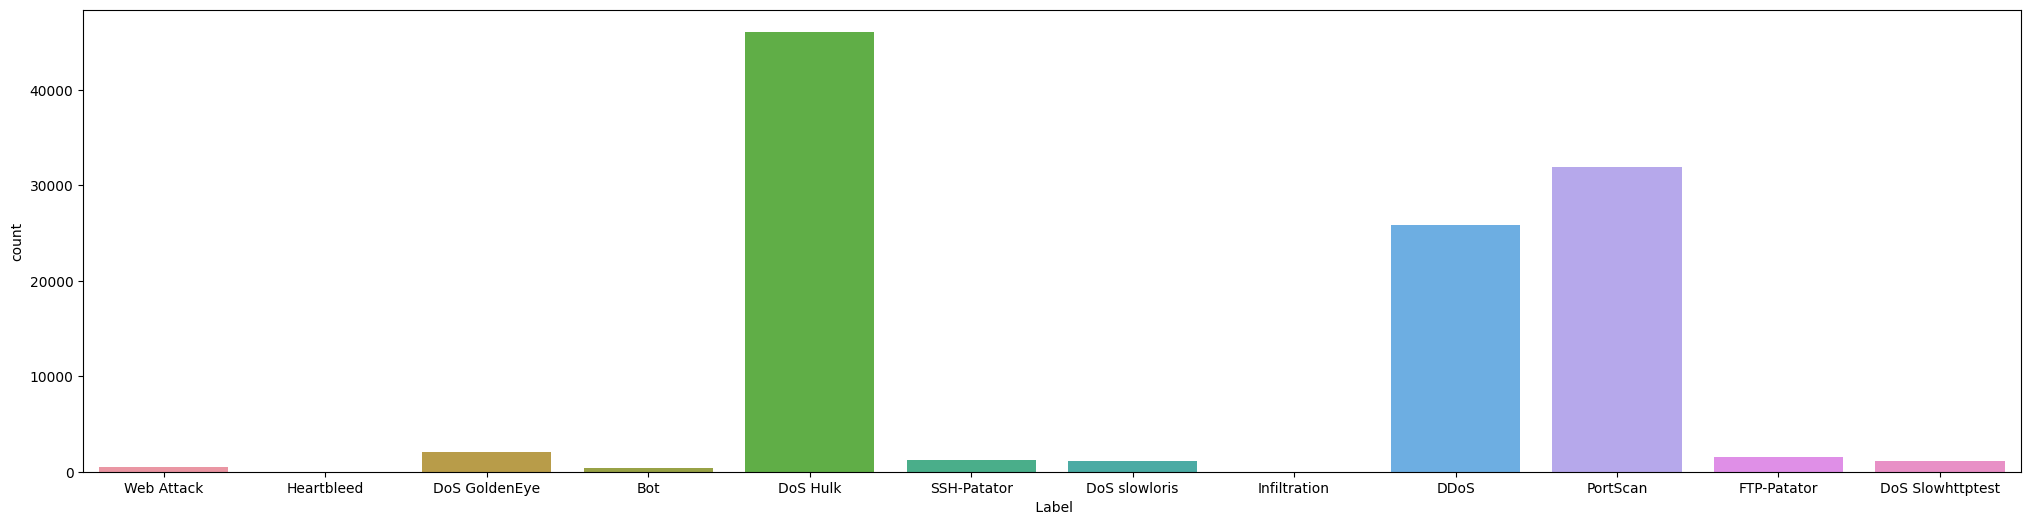

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_3_train = df_malicious_train.copy()
df_3_test = df_malicious_test.copy()

df_3_train.loc[df_3_train[' Label'] =='Web Attack � Brute Force', ' Label'] = 'Web Attack'
df_3_train.loc[df_3_train[' Label'] =='Web Attack � Sql Injection', ' Label'] = 'Web Attack'
df_3_train.loc[df_3_train[' Label'] =='Web Attack � XSS', ' Label'] = 'Web Attack'

df_3_test.loc[df_3_test[' Label'] =='Web Attack � Brute Force', ' Label'] = 'Web Attack'
df_3_test.loc[df_3_test[' Label'] =='Web Attack � Sql Injection', ' Label'] = 'Web Attack'
df_3_test.loc[df_3_test[' Label'] =='Web Attack � XSS', ' Label'] = 'Web Attack'

fig = plt.figure(figsize=(25,6))
sns.countplot(x=' Label', data=df_3_train)
plt.show()

fig = plt.figure(figsize=(25,6))
sns.countplot(x = ' Label', data=df_3_test)
plt.show()

0.999642138224111
                  precision    recall  f1-score   support

             Bot       1.00      1.00      1.00       379
            DDoS       1.00      1.00      1.00     25824
   DoS GoldenEye       1.00      1.00      1.00      2066
        DoS Hulk       1.00      1.00      1.00     46092
DoS Slowhttptest       1.00      0.99      0.99      1116
   DoS slowloris       0.99      1.00      1.00      1148
     FTP-Patator       1.00      1.00      1.00      1586
      Heartbleed       1.00      1.00      1.00         4
    Infiltration       1.00      1.00      1.00         5
        PortScan       1.00      1.00      1.00     31901
     SSH-Patator       1.00      1.00      1.00      1198
      Web Attack       0.99      0.99      0.99       456

        accuracy                           1.00    111775
       macro avg       1.00      1.00      1.00    111775
    weighted avg       1.00      1.00      1.00    111775



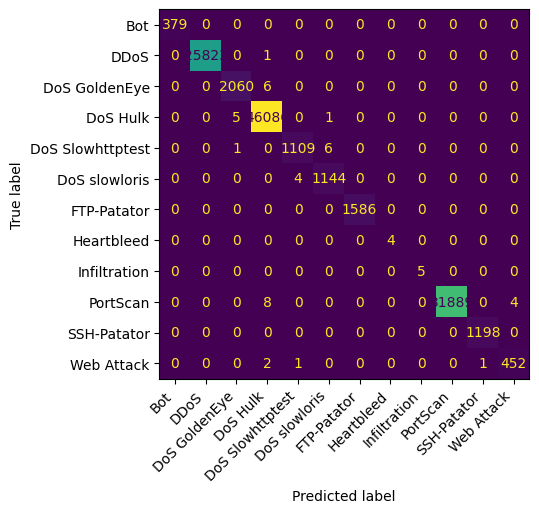

In [14]:
# use randomforest calssifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

df_3_train
X_train = df_3_train[df_3_train.columns[:-1]]
y_train = df_3_train[df_3_train.columns[-1]]

X_test = df_3_test[df_3_test.columns[:-1]]
y_test = df_3_test[df_3_test.columns[-1]]

rfc = RandomForestClassifier().fit(X_train, y_train)

# ??? classification report stuff
pred = rfc.predict(X_test)
print(accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot(colorbar=False)
plt.xticks(rotation=45, ha='right')
plt.show()

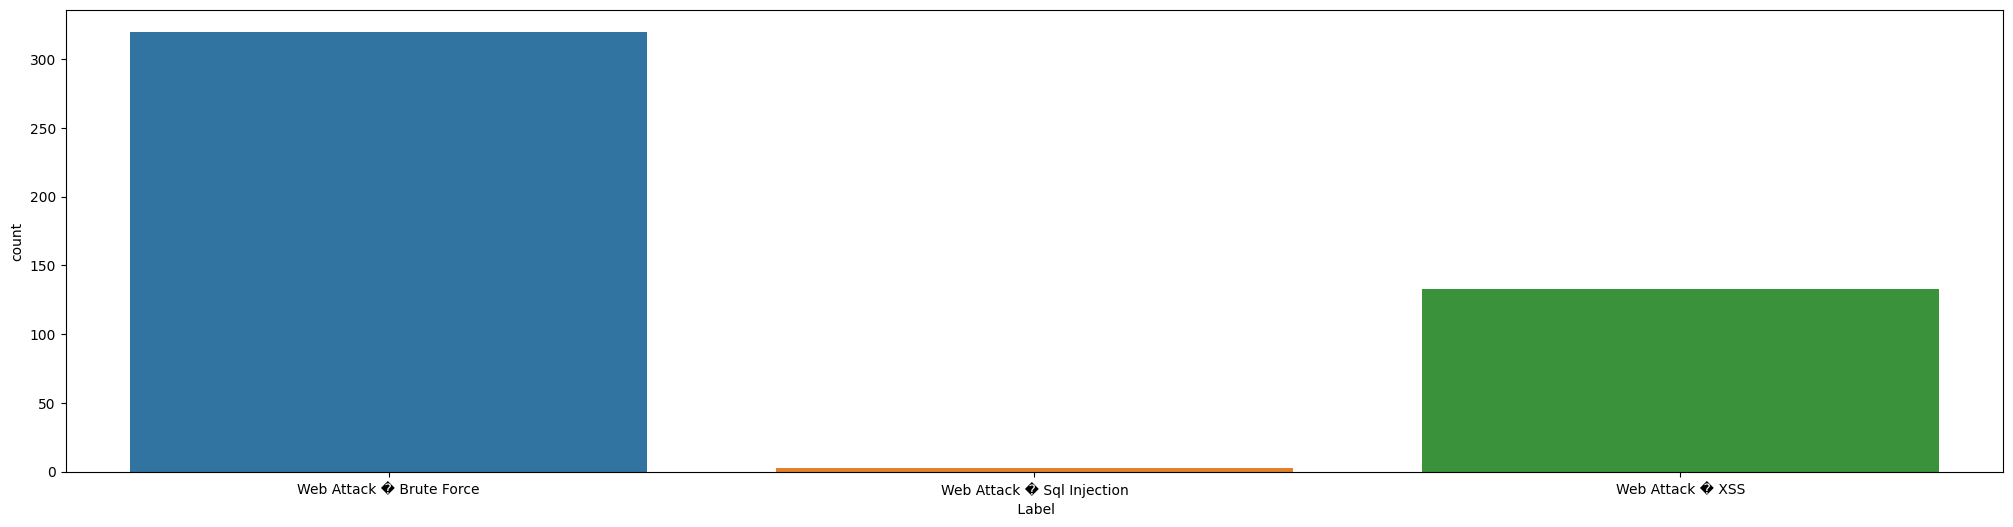

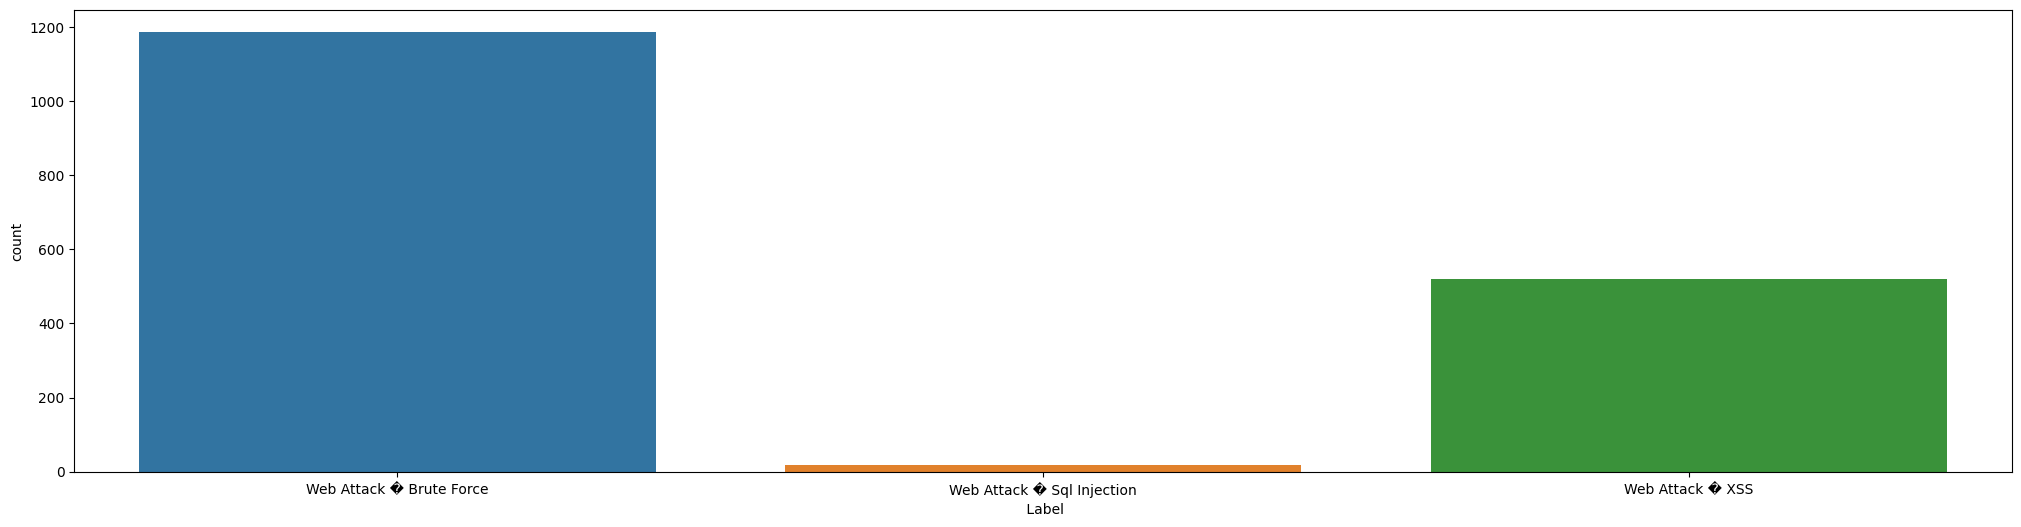

In [17]:
# train classifier for web attacks, extract web attacks data
#### WEB ATTACK
df_web_train = []
web_attack_labels = ['Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']
for web_label in web_attack_labels:
  df_web_i = df_malicious_train[df_malicious_train[' Label'] == web_label].copy()
  df_web_train.append(df_web_i)

df_web_train = pd.concat(df_web_train)


df_web_test = []
for web_label in web_attack_labels:
  df_web_i = df_malicious_test[df_malicious_test[' Label'] == web_label].copy()
  df_web_test.append(df_web_i)

df_web_test = pd.concat(df_web_test)


fig = plt.figure(figsize=(25,6))
sns.countplot(x = ' Label', data=df_web_test)
plt.show()

fig = plt.figure(figsize=(25,6))
sns.countplot(x = ' Label', data=df_web_train)
plt.show()

0.6600877192982456
                            precision    recall  f1-score   support

  Web Attack � Brute Force       0.73      0.81      0.77       320
Web Attack � Sql Injection       1.00      0.67      0.80         3
          Web Attack � XSS       0.40      0.30      0.34       133

                  accuracy                           0.66       456
                 macro avg       0.71      0.59      0.64       456
              weighted avg       0.64      0.66      0.65       456



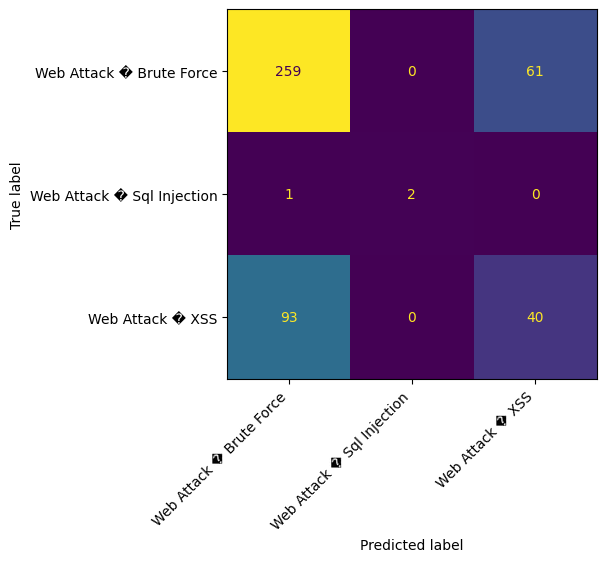

In [18]:
# training using rfc

# use randomforest calssifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

X_train = df_web_train[df_web_train.columns[:-1]]
y_train = df_web_train[df_web_train.columns[-1]]

X_test = df_web_test[df_web_test.columns[:-1]]
y_test = df_web_test[df_web_test.columns[-1]]

rfc = RandomForestClassifier().fit(X_train, y_train)

# ??? classification report stuff
pred = rfc.predict(X_test)
print(accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot(colorbar=False)
plt.xticks(rotation=45, ha='right')
plt.show()

0.7083333333333334
                            precision    recall  f1-score   support

  Web Attack � Brute Force       0.71      0.99      0.83       320
Web Attack � Sql Injection       0.00      0.00      0.00         3
          Web Attack � XSS       0.83      0.04      0.07       133

                  accuracy                           0.71       456
                 macro avg       0.51      0.34      0.30       456
              weighted avg       0.74      0.71      0.60       456



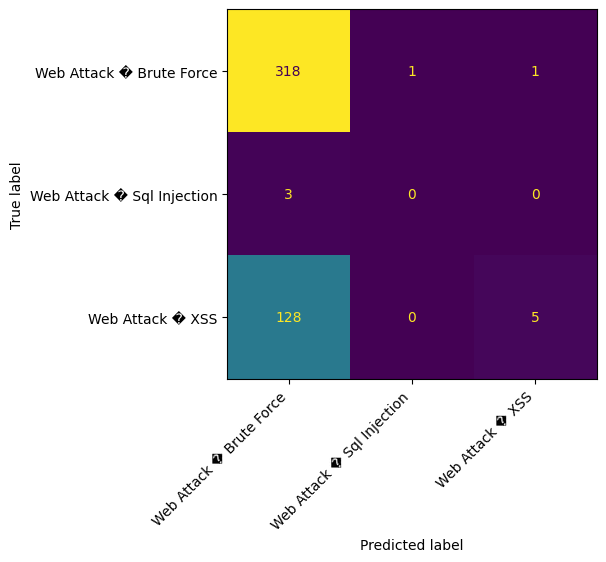

0.39035087719298245
                            precision    recall  f1-score   support

  Web Attack � Brute Force       0.79      0.18      0.29       320
Web Attack � Sql Injection       0.00      0.00      0.00         3
          Web Attack � XSS       0.32      0.91      0.47       133

                  accuracy                           0.39       456
                 macro avg       0.37      0.36      0.25       456
              weighted avg       0.65      0.39      0.34       456



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


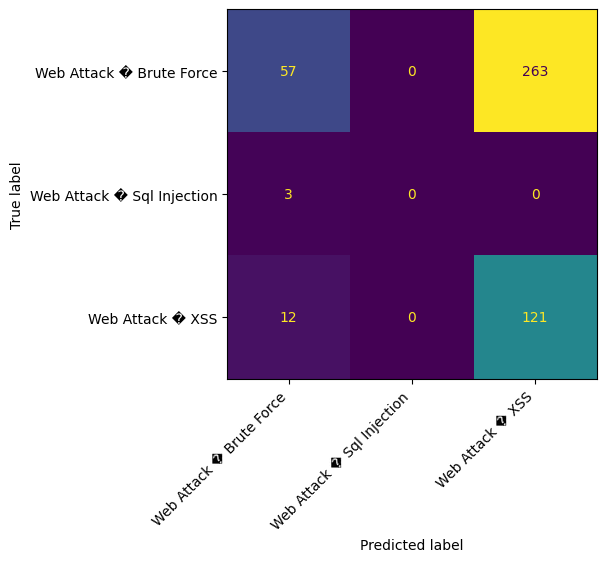

0.6447368421052632
                            precision    recall  f1-score   support

  Web Attack � Brute Force       0.73      0.78      0.75       320
Web Attack � Sql Injection       0.50      0.67      0.57         3
          Web Attack � XSS       0.39      0.33      0.36       133

                  accuracy                           0.64       456
                 macro avg       0.54      0.59      0.56       456
              weighted avg       0.63      0.64      0.64       456



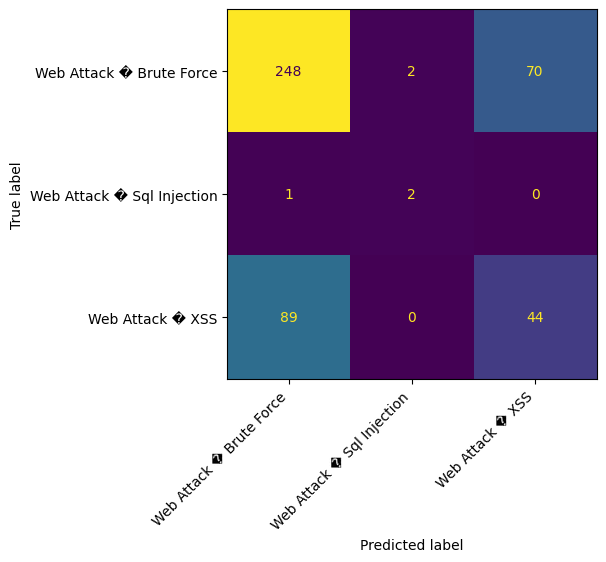

0.31140350877192985
                            precision    recall  f1-score   support

  Web Attack � Brute Force       0.94      0.05      0.09       320
Web Attack � Sql Injection       0.06      1.00      0.11         3
          Web Attack � XSS       0.32      0.93      0.48       133

                  accuracy                           0.31       456
                 macro avg       0.44      0.66      0.22       456
              weighted avg       0.75      0.31      0.20       456



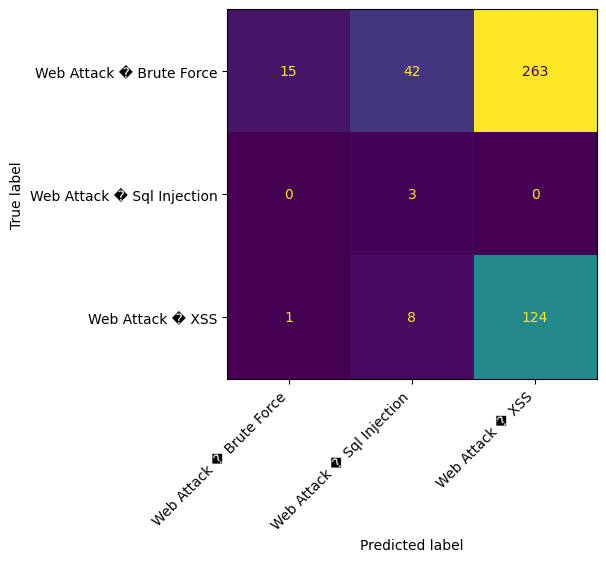

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(40,), random_state=1, max_iter=500).fit(X_train, y_train)

# X_train = df_web_train[df_web_train.columns[:-1]]
# y_train = df_web_train[df_web_train.columns[-1]]

# X_test = df_web_test[df_web_test.columns[:-1]]
# y_test = df_web_test[df_web_test.columns[-1]]
models = [mlp, AdaBoostClassifier().fit(X_train, y_train), ExtraTreesClassifier().fit(X_train, y_train), GaussianNB().fit(X_train, y_train)]
for model in models:
  # ??? classification report stuff
  pred = model.predict(X_test)
  print(accuracy_score(pred, y_test))
  print(classification_report(y_test, pred))

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  cm = confusion_matrix(y_test, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
  disp.plot(colorbar=False)
  plt.xticks(rotation=45, ha='right')
  plt.show()